<a href="https://colab.research.google.com/github/jmontano1987/pdg/blob/main/Proyecto_de_Grado_version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Proyecto de Grado**

**Título:** Modelo para la detección de Noticias Falsas en tweets con formato de texto en el contexto político colombiano para las elecciones del año 2022.

**Integrantes:**
* Jesus Eduardo Flores Q.
* Juan Gabriel Montaño M.

#**Instalaciones**

In [1]:
!pip install tweepy
!pip3 install tqdm
!pip install spacy
!pip install matplotlib
!pip install wordcloud
!pip install unidecode
!pip install scikit-plot
!pip install bayesian-optimization
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz
!pip install stop-words

     |████████████████████████████████| 235 kB 2.7 MB/s 
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=6b37b21c00644c1bf296c4e241c1f6a693ef06a7ec3c23c040eff07f05c0b086
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization
     |████████████████████████████████| 12.0 MB 2.6 MB/s 
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.0-py3-none-any.whl size=12019121 sha256=60e57c89e579f8cf80ac16bf39771ee430de54974f6fb8438ddbc34c1d72713b
  Stored in directory: /root/.cache/pip/wheels/64/69/41/6f820cf1d7488a0381a2059f66ec9f8f23116f7c67d18f3d8d
Successfully built en-core-web-sm
  Attempting uninstall: en-core-web-sm
    Found existing installation: en-core-web-sm 2.2.5
    Uninstalling en-core-web-sm-2.2.5:
      Successfully uninstalled en-core-web-sm-2.2.5
  Created wheel for stop-words: filename=stop_words-2018.7.23-p

#**Librerias**

In [2]:
import io
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np
import string
import tweepy
from tqdm.notebook import tqdm as tqdm_notebook
from dateutil import tz
from datetime import datetime 
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import unidecode
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import requests
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import random
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import scikitplot as skplt
from sklearn.linear_model import LogisticRegression
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
from google.colab import (
    drive,
    files
)
from tqdm import tqdm
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from stop_words import get_stop_words
import pickle
import xgboost as xgb
from sklearn.linear_model import PassiveAggressiveClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#**Funciones**

In [3]:
#Funcion que convierte el formato de la fecha del tweet en hora GMT -5 Colombia
def convert_date(str_date):
  str_format_date = '%Y-%m-%d %H:%M:%S' 
  from_zone = tz.gettz('UTC')
  to_zone = tz.gettz('America/Bogota')
  date_convert = datetime.strptime(str(str_date), str_format_date)
  date_convert = date_convert.replace(tzinfo=from_zone)
  date_convert = date_convert.astimezone(to_zone)
  date_convert = datetime.strftime(date_convert,'%d/%m/%Y %H:%M:%S')
  return date_convert

In [4]:
#Funcion para obtener los tweets de un usuario especifio de twitter - Se quitan los RT
def get_tweets(api,username,items,rts):
  tweets={}
  for tweet in tqdm_notebook(tweepy.Cursor(api.user_timeline, screen_name = username, tweet_mode='extended',include_rts=rts).items(items)):
      tweets[tweet.id]= {
          'full_text': tweet.full_text,
          'created_at': convert_date(tweet.created_at),
          'author_name': tweet.user.name,
          'author_handler': str(tweet.user.screen_name),
          'user_description': tweet.user.description,
          'user_location': tweet.user.location,
          'user_followers_count': tweet.user.followers_count,
          'user_created_at': convert_date(tweet.user.created_at),
          'user_following_count': tweet.user.friends_count,
          'user_verified': tweet.user.verified,
          'lang': tweet.lang,
          'tweet_hashtags': tweet.entities['hashtags'],
          'mention_names': ["@" + d['screen_name'] for d in tweet.entities['user_mentions'] if 'screen_name' in d],
          'mention_ids': [d['id'] for d in tweet.entities['user_mentions'] if 'id' in d],
          'n_retweets': tweet.retweet_count,
          'n_favorites': tweet.favorite_count,
          'is_retweet': hasattr(tweet, 'retweeted_status')
      }
  df_tweets = pd.DataFrame.from_dict(tweets, orient='index')
  df_tweets['id'] = df_tweets.index
  return df_tweets

In [5]:
def remove_newlines_tabs(text):
 # Remover saltos de linea
  formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\\', ' ')
  return formatted_text

In [6]:
def remove_whitespace(text):
  # Remover espacios en blanco
    pattern = re.compile(r'\s+') 
    without_whitespace = re.sub(pattern, ' ', text)
    text = without_whitespace.replace(')', ') ')
    text=text.replace("  ", " ").replace("   ", " ").replace("    ", " ").lstrip()
    text=text.replace("  ", " ").replace("   ", " ").replace("    ", " ").rstrip()
    text=text.replace("   ", "")
    return text    

In [7]:
def accented_characters_removal(text):
  # Remover tildes
    text = unidecode.unidecode(text)
    return text

In [8]:
def remove_special_characters(text):
    # Remover caracteres especiales
    return text.translate(str.maketrans('','',string.punctuation))

In [9]:
def lower_text(text):
    # Convertir mayusculas a minusculas
    text = text.lower()
    return text

In [10]:
stoplist = list(get_stop_words('spanish'))  # 308 words
nltk_words = list(stopwords.words('spanish')) #
stoplist.extend(nltk_words)
def remove_stopwords(text):
    # Remover stop words
    nostopwords = [word for word in word_tokenize(text) if word.lower() not in stoplist ]
    # Convertir lista en tipo String
    words_string = ' '.join(nostopwords)   
    return words_string

In [11]:
nlp = spacy.load('en_core_web_sm')
def lemmatizer(text):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

In [12]:
def remove_links(text): 
    # Remover urls 
    text=re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+",'',text)
    text=re.sub(r'https?://\S+|www\.\S+','',text)
    text=re.sub(r'opr-littps://S+','',text)
    return text

In [13]:
def remove_numbers(text):
    # Remover numeros
    formatted_text=''.join((x for x in text if not x.isdigit()))
    formatted_text= re.sub(r"NUMBER", ' ', formatted_text)
    formatted_text= re.sub(r"number", ' ', formatted_text)
    return formatted_text

In [14]:
def text_preprocessing(text, accented_chars=True, newlines_tabs=True, extra_whitespace=True,lowercase=True,characters_specials=True,stop_words=True,lemmatization = True,links=True,numbers_remove=True):     

    if newlines_tabs == True:  # Remover saltos de linea
        data = remove_newlines_tabs(text) 
   
    if links == True: #remove links
        data = remove_links(data)
        
    if extra_whitespace == True: # Remover espacios en blanco
        data = remove_whitespace(data)
    
    if lowercase == True: # Convertir mayusculas a minusculas
        data = lower_text(data)
    
    if characters_specials == True: # Remover caracteres especiales
        data = remove_special_characters(data)

    if numbers_remove == True: # Remover numeros
        data = remove_numbers(data)

    if accented_chars == True: # Remover tildes
        data = accented_characters_removal(data) 

    if stop_words == True: # Remover stopwords
        data = remove_stopwords(data) 

    if lemmatization == True: # Lematizacion
       data = lemmatizer(data)

    if characters_specials == True: # Remover caracteres especiales
        data = remove_special_characters(data)

    if extra_whitespace == True: # Remover espacios en blanco
        data = remove_whitespace(data)    
       
    return data

In [15]:
def change_categories(campo):
    if campo=='True' or campo=='Noticia Real':
        return 'Noticia Real'
    else:
        return 'Noticia Falsa'

In [16]:
def create_model_production(name_model,model):
  with open(name_model+'.pkl','wb') as model_pkl:
    pickle.dump(model, model_pkl, protocol=2)

In [133]:
def randomsearchmodels(model,hyperparameters_tuning,features_train_f,labels_train_f,features_test_f,labels_test_f):
  gridsearch = RandomizedSearchCV(model,hyperparameters_tuning,n_iter=150,scoring='accuracy',cv=3,verbose=1,random_state=8)
  gridsearch.fit(features_train_f,labels_train_f)
  predictions = gridsearch.predict(features_test_f)
  accuracy_model=accuracy_score(predictions, labels_test_f)
  return gridsearch,predictions,accuracy_model

In [18]:
def tifdf_features (X_train, X_test, y_train, y_test,ngram_range,max_df,min_df,max_features):
  tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
  features_train = tfidf.fit_transform(X_train)
  features_test = tfidf.transform(X_test)
  labels_train = y_train
  labels_test = y_test
  return features_train,features_test,labels_train,labels_test,tfidf

#**Twitter**

Credenciales Consumo API

In [19]:
# API Keys para autenticacion
api_key = "UcZ9gR5yMV4MlKTFaSwhC1aNX" 
api_secret = "R5BjKcmHan6MGaX98UMhytQfLiZI7TLl9AATGtixJLwmAU2DFR"
access_token = "1452452402070794241-rKitK0leSslMs9XoXEDBTxOwplOGGU"
access_token_secret = "lBAxKokr4Hkg3DxvaUMTWkAqU0E9O5KfZCmJoPulnfSRn"

In [20]:
# Autorización para consumo API
auth = tweepy.OAuthHandler(api_key, api_secret) 
# Acceso al API
auth.set_access_token(access_token, access_token_secret) 
# Instancia para llamar a la API 
api = tweepy.API(auth, wait_on_rate_limit=True) 

In [21]:
#Obtener Tweets de cuenta
df_tweets=get_tweets(api,"petrogustavo",10,False)

0it [00:00, ?it/s]

In [22]:
df_tweets.full_text.iloc[0]

'En una de cada cuatro mesas no aparecen votos por el Pacto al Congreso en todo el país, y en una de cada cuatro mesas a las listas abiertas le duplicaron los votos sumando logo y número de candidato.\n\nHay que escrutar cada una de esas mesas. https://t.co/QL9JejvJB6'

#**Cargar Corpus**

In [23]:
"""
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials
auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

link ="https://docs.google.com/spreadsheets/d/1Z6pTbEbxGQZPafhL0z8M9ljqb0hk6Fe-/edit?usp=sharing&ouid=101698352442646923002&rtpof=true&sd=true"
id = link.split("/")[-2] 
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Corpus_Noticias_Falsas.xlsx') 

link= "https://docs.google.com/spreadsheets/d/1sSQtclY20wglbQgjQmcdM-Hm6N_U67GI/edit?usp=sharing&ouid=101698352442646923002&rtpof=true&sd=true"
id = link.split("/")[-2] 
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.xlsx') 

link= "https://drive.google.com/file/d/1HfYrfCJV-DznorSvRW2Om8YYDbB0Ehhr/view?usp=sharing"
id = link.split("/")[-2] 
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('stop_words_spanish.txt') 
"""

'\nfrom pydrive.auth import GoogleAuth \nfrom pydrive.drive import GoogleDrive \nfrom google.colab import auth \nfrom oauth2client.client import GoogleCredentials\nauth.authenticate_user() \ngauth = GoogleAuth() \ngauth.credentials = GoogleCredentials.get_application_default() \ndrive = GoogleDrive(gauth)\n\nlink ="https://docs.google.com/spreadsheets/d/1Z6pTbEbxGQZPafhL0z8M9ljqb0hk6Fe-/edit?usp=sharing&ouid=101698352442646923002&rtpof=true&sd=true"\nid = link.split("/")[-2] \ndownloaded = drive.CreateFile({\'id\':id}) \ndownloaded.GetContentFile(\'Corpus_Noticias_Falsas.xlsx\') \n\nlink= "https://docs.google.com/spreadsheets/d/1sSQtclY20wglbQgjQmcdM-Hm6N_U67GI/edit?usp=sharing&ouid=101698352442646923002&rtpof=true&sd=true"\nid = link.split("/")[-2] \ndownloaded = drive.CreateFile({\'id\':id}) \ndownloaded.GetContentFile(\'train.xlsx\') \n\nlink= "https://drive.google.com/file/d/1HfYrfCJV-DznorSvRW2Om8YYDbB0Ehhr/view?usp=sharing"\nid = link.split("/")[-2] \ndownloaded = drive.CreateFil

Los archivos pueden ser cargados de manera local:

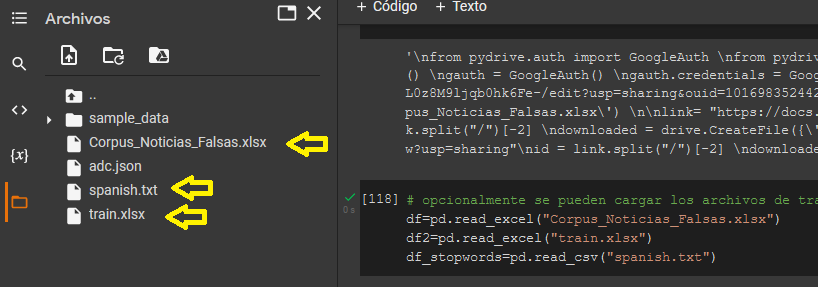

In [24]:
# opcionalmente se pueden cargar los archivos de trabajo desde el area de trabajo local. Estos se deben cargar previamente 
df=pd.read_excel("Corpus_Noticias_Falsas.xlsx")
df2=pd.read_excel("train.xlsx")
df_stopwords=pd.read_csv("spanish.txt")

In [25]:
df=df[['Categoria','Texto']] # Corpus creado por Eduardo Flores y Juan Montano
df

Categoria                                              Texto
0    Noticia Real  El presidente Iván Duque condenó fuertemente e...
1    Noticia Real  Gustavo Petro se reunirá con Pedro Sánchez, pr...
2    Noticia Real  Marta Lucía Ramírez se queja por servicio en e...
3    Noticia Real  Elecciones de 2022 requieren mayor cuidado, po...
4    Noticia Real  ANTE LA expansión de la variante ómicron en el...
..            ...                                                ...
492  Noticia Real  Los pasacalles de la campaña de Comunes en Pue...
493  Noticia Real  En medio de uno de los momentos más difíciles ...
494  Noticia Real  Entre el sábado 29 de enero y el viernes 11 de...
495  Noticia Real  El presidente Iván Duque respondió a la decisi...
496  Noticia Real  En medio de una operación militar desplegada d...

[497 rows x 2 columns]

In [26]:
#stoplist.clear() : funcion para borra el contenido de la lista
stoplist.extend(df_stopwords['stopwords'].tolist())
len(stoplist)

1233

In [27]:
# eliminar las tildes de los stopword para la limpieza.
list_stop_words = []
for n in stoplist:
  list_stop_words.append(unidecode.unidecode(n))
stoplist=list_stop_words

In [28]:
df.value_counts(df['Categoria'])

Categoria
Noticia Real     260
Noticia Falsa    237
dtype: int64

In [29]:
## seleccionar las dos columans de trabajo
df2=df2[['Category','Text']] # Corpus Posadas-Duran
df2

Category                                               Text
0       Fake  RAE INCLUIRÁ LA PALABRA "LADY" EN EL DICCIONAR...
1       Fake  La palabra "haiga", aceptada por la RAE La Rea...
2       Fake  YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...
3       True  UNAM capacitará a maestros para aprobar prueba...
4       Fake  Alerta: pretenden aprobar libros escolares con...
..       ...                                                ...
671     Fake  Madonna será la nueva imagen del Chocolate Abu...
672     True  Filtran material íntimo de Zelina Vega, luchad...
673     Fake  CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...
674     Fake  TV Azteca anuncia que cambiará su nombre por u...
675     Fake  MUERTE DE PETER EL ANGUILA POR SOBREDOSIS\nPet...

[676 rows x 2 columns]

In [30]:
# se renombran las columas para realizar la union de los dos corpus
df2=df2.rename(columns={'Category':'Categoria', 'Text':'Texto'})

In [31]:
df2.value_counts('Categoria')

Categoria
Fake    338
True    338
dtype: int64

In [32]:
#Dataframe con 500 noticias
df_base_cp=df

In [33]:
#Union de los dos corpus
df_base=pd.concat([df,df2], axis=0, ignore_index=False)

In [34]:
df_base.Categoria.value_counts()

Fake             338
True             338
Noticia Real     260
Noticia Falsa    237
Name: Categoria, dtype: int64

In [35]:
# cambiar el nombre de la categoria para dejar el corpus uniforme: Fake=Noticia Falsa, True=Noticia Real
df_base["Categoria"]=df_base["Categoria"].apply(change_categories)
df_base

Categoria                                              Texto
0     Noticia Real  El presidente Iván Duque condenó fuertemente e...
1     Noticia Real  Gustavo Petro se reunirá con Pedro Sánchez, pr...
2     Noticia Real  Marta Lucía Ramírez se queja por servicio en e...
3     Noticia Real  Elecciones de 2022 requieren mayor cuidado, po...
4     Noticia Real  ANTE LA expansión de la variante ómicron en el...
..             ...                                                ...
671  Noticia Falsa  Madonna será la nueva imagen del Chocolate Abu...
672   Noticia Real  Filtran material íntimo de Zelina Vega, luchad...
673  Noticia Falsa  CBS PLANEA GRAN HERMANO EN LA CASA BLANCA CON ...
674  Noticia Falsa  TV Azteca anuncia que cambiará su nombre por u...
675  Noticia Falsa  MUERTE DE PETER EL ANGUILA POR SOBREDOSIS\nPet...

[1173 rows x 2 columns]

In [36]:
# Conteo del numero de noticias falsas y verdaderas.
df_base.Categoria.value_counts()

Noticia Real     598
Noticia Falsa    575
Name: Categoria, dtype: int64

In [37]:
#Dataframe con 1000 noticias - Union Corpus JM y Posadas-Duran
df_merge=df_base

#**Preprocesamiento**

Tareas de pre-procesamiento a realizar:
* Convertir Mayusculas a minusculas
* Remover links
* Remover números
* Remover signos de puntuación
* Remover tildes
* Remover comillas
* Remover retornos y lineas nuevas
* Remover StopWords
* Lematización

### **Preprocesamiento Corpus del proyecto**

In [38]:
#Preprocesamiento Corpus 500 noticias
List_News = df_base_cp['Texto'].to_list()
Final_News = []
Complete_Content = []
for news in tqdm(List_News):
    Processed_Content = text_preprocessing(news)
    Final_News.append(Processed_Content)
Complete_Content.extend(Final_News)
df_base_cp['Processed_Text'] = Complete_Content

100%|██████████| 497/497 [00:08<00:00, 55.41it/s]


### **Preprocesamiento Corpus Unido**

In [39]:
#Preprocesamiento Corpus 1000 noticias
List_News = df_merge['Texto'].to_list()
Final_News = []
Complete_Content = []
for news in tqdm(List_News):
    Processed_Content = text_preprocessing(news)
    Final_News.append(Processed_Content)
Complete_Content.extend(Final_News)
df_merge['Processed_Text'] = Complete_Content

100%|██████████| 1173/1173 [00:39<00:00, 29.75it/s]


In [40]:
df_merge.Texto.iloc[1093]

'Carlos Trejo producirá, dirigirá y protagonizará la versión mexicana de "Los Cazafantasmas"\nMéxico.- El investigador de fenómenos paranormales, Carlos Trejo, anunció que en mayo iniciará el rodaje de la versión mexicana de la película "Los Cazafantasmas", cinta que él producirá, dirigirá y protagonizará junto con otros reconocidos actores nacionales.\nTrejo mencionó que –a diferencia del film original- su película tratará el tema de los fantasmas de manera seria y respetuosa, y no con las "payasadas" de la versión americana:\n"Como ya todos saben yo estuve a punto de morir por culpa de un espectro del más allá que atormentó a mi familia cuando vivíamos en Cañitas. Las situaciones paranormales son un tema serio y delicado, me parece una grosería que Hollywood saque una película bufándose de esta terrible situación, eso demuestra que no les importa hacer cine de calidad, prefieren producir películas tontas y huecas con tal de llenarse los bolsillos de dinero en vez de realizar cine de 

In [41]:
a="Carlos Trejo producirá, dirigirá y protagonizará la versión mexicana de Los Cazafantasmas México.- El investigador de fenómenos paranormales, Carlos Trejo, anunció que en mayo iniciará el rodaje de la versión mexicana de la película \"Los Cazafantasmas\", cinta que él producirá, dirigirá y protagonizará junto con otros reconocidos actores nacionales.\nTrejo mencionó que –a diferencia del film original- su película tratará el tema de los fantasmas de manera seria y respetuosa, y no con las \"payasadas\" de la versión americana:\n\"Como ya todos saben yo estuve a punto de morir por culpa de un espectro del más allá que atormentó a mi familia cuando vivíamos en Cañitas. Las situaciones paranormales son un tema serio y delicado, me parece una grosería que Hollywood saque una película bufándose de esta terrible situación, eso demuestra que no les importa hacer cine de calidad, prefieren producir películas tontas y huecas con tal de llenarse los bolsillos de dinero en vez de realizar cine de calidad\", señaló.\nCarlos mencionó que no es uh novato en el cine ya que su libro \"Cañitas\" fue adaptado a la pantalla grande en el *NUMBER*:\n\"Siempre tuve la espinita de producir películas de calidad para engrandecer a nuestro nacional. Ahora que Hollywood va a estrenar la versión femenina de los Cazafantasmas quise producir la versión mexicana para demostrarles que nuestro cine tiene muchísima mejor calidad y es más profundo. Quiero hacer de esta película toda una obra de arte\", señaló.\nTrejo mencionó que su película será un drama y no comedia, además de que los cazafantasmas de su film intentarán atrapar espectros reales que él ha conocido:\n\"Los fantasmas que verán en mi cinta serán fantasmas reales con los que he convivido a través de los años. Mi película será una especie de documental que le mostrará al mundo que no estamos solos y que estos espectros son peligrosos, pero que afortunadamente hay personas como yo que estamos dispuesto a dar la vida con tal de controlarlos para que no dañen al mundo\", señaló.\nPor último, Trejo confirmó que el grupo de cazafantamas mexicanos estará integrado (además de él) por los actores Adrián Uribe, Omar Chaparro, Martha Higareda (la única mujer en el grupo) y el investigador en fenómenos extraterrestres Jaime Maussan, con quien recientemente hizo las pases."
b=unidecode.unidecode(a,'utf-8')
c=remove_special_characters(b)
d=remove_stopwords(c)
d


'Carlos Trejo producira dirigira protagonizara version mexicana Cazafantasmas investigador fenomenos paranormales Carlos Trejo anuncio mayo iniciara rodaje version mexicana pelicula Cazafantasmas cinta producira dirigira protagonizara reconocidos actores nacionales Trejo diferencia film original pelicula tratara tema fantasmas respetuosa payasadas version americana punto morir culpa espectro alla atormento familia viviamos Canitas situaciones paranormales tema serio delicado groseria Hollywood saque pelicula bufandose terrible situacion demuestra importa cine calidad prefieren producir peliculas tontas huecas llenarse bolsillos dinero cine calidad Carlos uh novato cine libro Canitas adaptado pantalla grande NUMBER espinita producir peliculas calidad engrandecer nacional Hollywood estrenar version femenina Cazafantasmas quise producir version mexicana demostrarles cine muchisima calidad profundo Quiero pelicula obra arte Trejo pelicula drama comedia cazafantasmas film intentaran atrapar

In [42]:
df_base_cp.Processed_Text.iloc[400]

'atencion noticia hombre identificado alias naruto personas coloco carro bomba academia policia bogota difundir quepagueporloquehizo'

In [43]:
df_merge.Processed_Text.iloc[200]

'ola atracos viene presentando area metropolitana bucaramanga extranjeros medio comunicacion comunica amanda duarte representante extranjeros santander pronuncio respeto gobierno diera subsidio mensual diera vivir mercado vivir colegas robaran mentalidad extranjeros dinero pais dia pais cambie dia llevamos dinero hagamos colombia gobierno colombia incumplio casa vivir beca estudiar colegas toca robar dinero pais'

In [44]:
df_merge.Processed_Text.iloc[1000]

'cdmx enfrenta contingencia falta agua presencia canal alta presion altas temperaturas afectaron distribucion mil habitante delegacione vecinos delegacion tlahuac cerraron tramo avenida nombre calle manifestar inconformidad falta agua potable padecen zonas ciudad delegaciones cuauhtemoc benito juarez iztapalapa iztacalco venustiano carranza azcapotzalco tlalpan enfrenta contingencia escasez baja presion agua acuerdo autoridades mil habitantes demarcaciones padecen escasez presencia atipica canal alta presion origino dejaran recibir mil litros agua sistema cutzamala altas temperaturas zonas incremento ciento consumo liquido situacion mermo distribucion part jose ramon aguirre director general sistema aguas ciudad detallo diez ciento ciudad mil habitantes hablamos emergencia contingencia presione bajas ciudad delegaciones cuauhtemoc benito juarez quejas vecinos baja presion zonas podido cumplir tandeo completo iztapalapa atienden quejas pipas agua iztacalco venustiano carranza azcapotzal

In [45]:
df_merge.Processed_Text.iloc[1093]

'carlos trejo producira dirigira protagonizara version mexicana cazafantasmas investigador fenomenos paranormale carlos trejo anuncio mayo iniciara rodaje version mexicana pelicula cazafantasmas cinta producira dirigira protagonizara reconocidos actores nacionales trejo a diferencia film original pelicula tratara tema fantasmas respetuosa payasadas version americana punto morir culpa espectro alla atormento familia viviamos canitas situaciones paranormale tema serio delicado groseria hollywood saque pelicula bufandose terrible situacion demuestra importa cine calidad prefieren producir peliculas tontas huecas llenarse bolsillos dinero cine calidad carlos uh novato cine libro canitas adaptado pantalla grande espinita producir peliculas calidad engrandecer nacional hollywood estrenar version femenina cazafantasma quise producir version mexicana demostrarle cine muchisima calidad profundo quiero pelicula obra arte trejo pelicula drama comedia cazafantasmas film intentaran atrapar espectro

###**División del Corpus - Noticias Falsas y Verdaderas**

In [46]:
#División Dataframe Corpus de referencia
real_news = df_merge[df_merge['Categoria'] == 'Noticia Real']
fake_news = df_merge[df_merge['Categoria'] == 'Noticia Falsa']

In [47]:
#División Dataframe Corpus creado
real_news_cp=df_base_cp[df_base_cp['Categoria'] == 'Noticia Real']
fake_news_cp = df_base_cp[df_base_cp['Categoria'] == 'Noticia Falsa']

# **Analitica Descriptiva**

## **Analitica Corpus Propio**

###**Histograma de categorias**

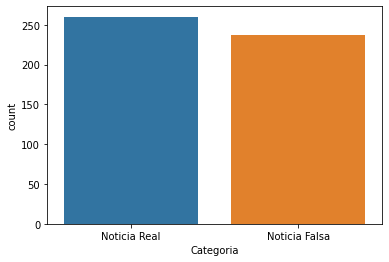

In [48]:
# Distribución de noticias falsas y verdaderas Corpus 500 noticias
ax = sns.countplot(x="Categoria", data=df_base_cp)

### Word Cloud Real News Corpus Propio

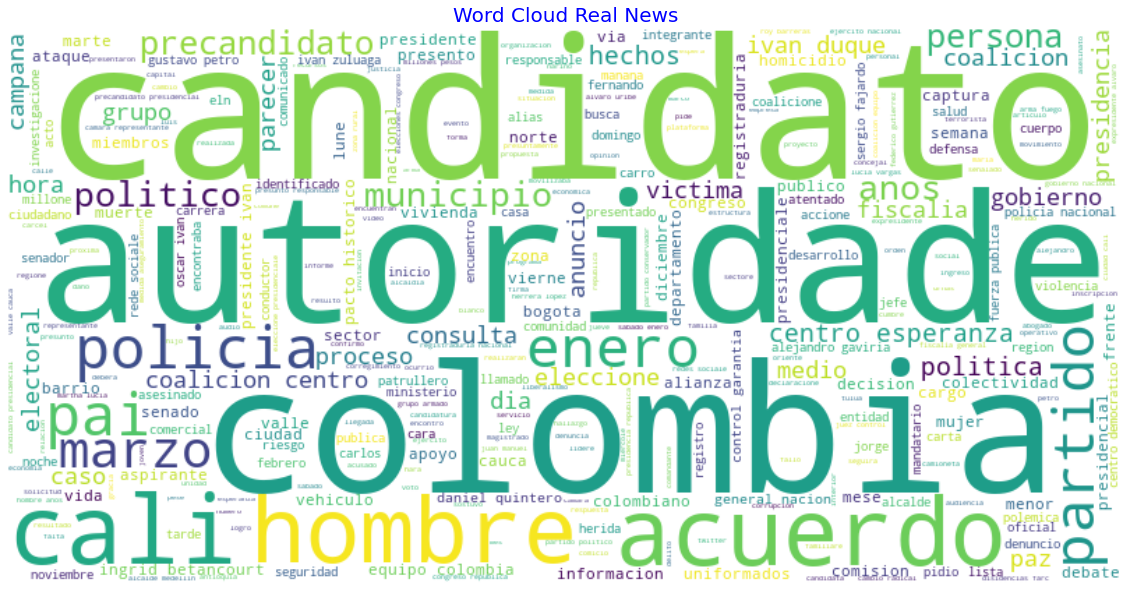

In [49]:
#Wordcloud 500 Noticias reales
wc = WordCloud(background_color="white", max_words=3000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(real_news_cp['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Real News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Word Cloud Fake News Corpus Propio

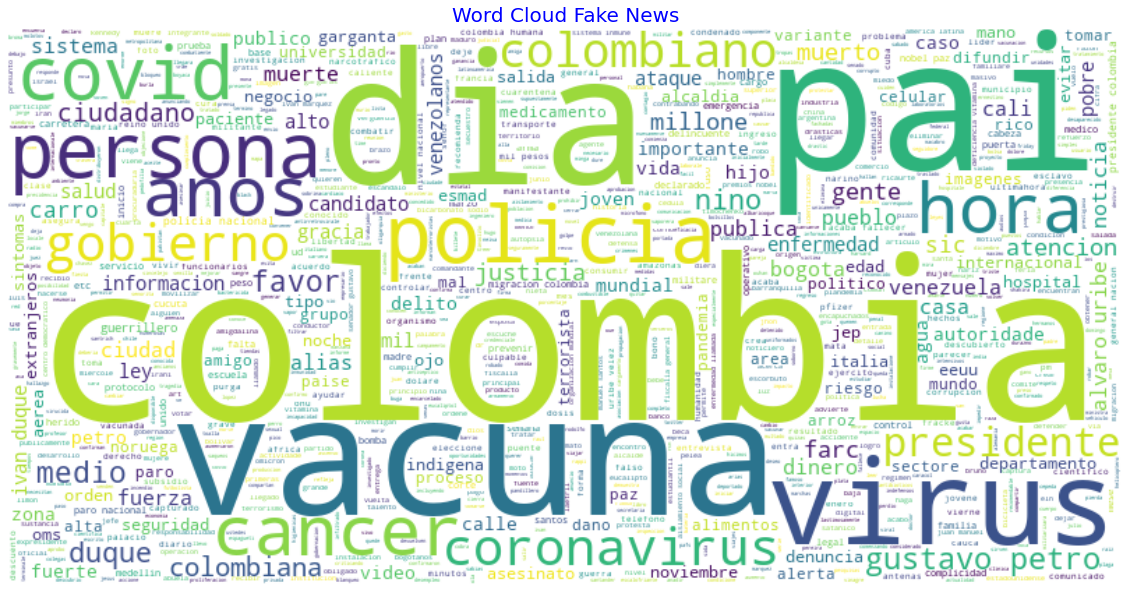

In [50]:
#Wordcloud 500 noticias falsas
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(fake_news_cp['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Fake News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## **Analitica Corpus Unido**

###**Histograma de categorias**

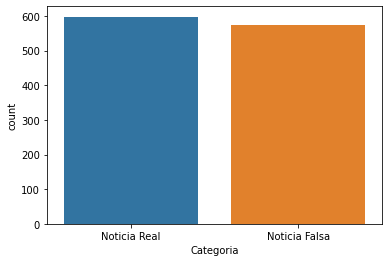

In [51]:
# Distribución de noticias falsas y verdaderas Corpus 1000 noticias
ax = sns.countplot(x="Categoria", data=df_merge)

### Word Cloud Fake News Corpus Unido

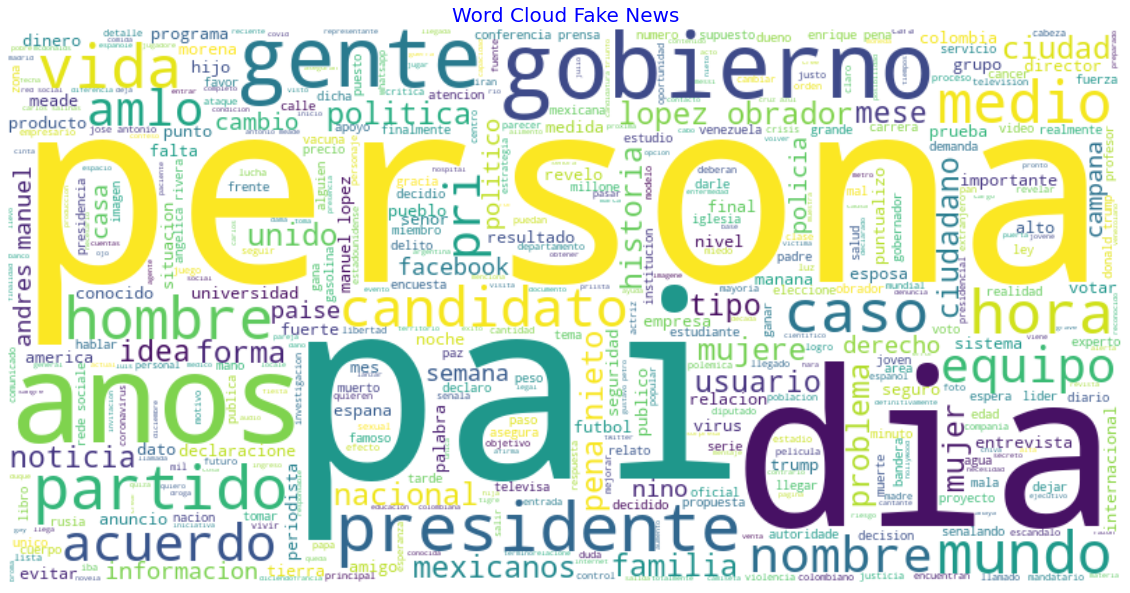

In [52]:
#Wordcloud 1000 noticias falsas
wc = WordCloud(background_color="white", max_words=2000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(fake_news['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Fake News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Word Cloud Real News Corpus Unido

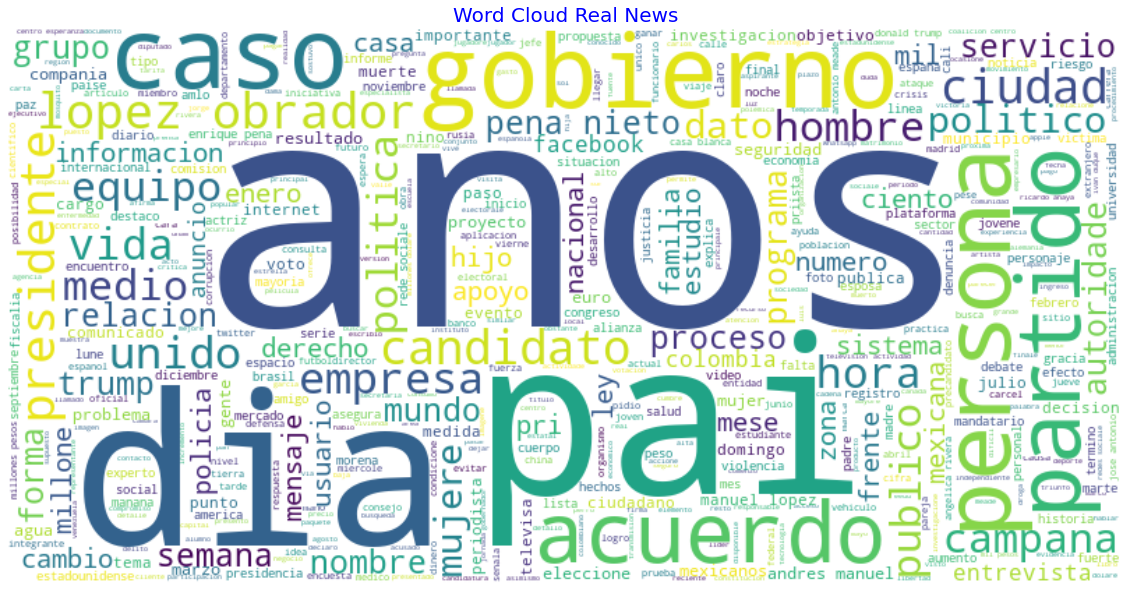

In [53]:
#Wordcloud 1000 Noticias reales
wc = WordCloud(background_color="white", max_words=3000, width=800, height=400,stopwords=stoplist)
wc.generate(' '.join(real_news['Processed_Text']))
plt.figure(figsize=(20, 15))
plt.title("Word Cloud Real News", fontsize=20,color='blue')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# **Modelamiento**

## Codificación de etiquetas

In [54]:
category_codes = {
     'Noticia Real': 0,
    'Noticia Falsa': 1
}

In [55]:
df_merge['Codigo'] = df_merge['Categoria']
df_merge = df_merge.replace({'Codigo':category_codes})

In [56]:
df_base_cp['Codigo'] = df_base_cp['Categoria']
df_base_cp = df_base_cp.replace({'Codigo':category_codes})

## División de datos

Se realiza el particionamiento de los datos en prueba y validación.

In [57]:
#Division de datos - Corpus propio
X_train_cp, X_test_cp, y_train_cp, y_test_cp = train_test_split(df_base_cp['Processed_Text'], 
                                                    df_base_cp['Codigo'], 
                                                    test_size=0.20, 
                                                    random_state=8)

In [58]:
#Division de datos - Corpus de referencia + Corpus creado = 1000 noticias
X_train, X_test, y_train, y_test = train_test_split(df_merge['Processed_Text'], 
                                                    df_merge['Codigo'], 
                                                    test_size=0.20, 
                                                    random_state=8)

## **Representación del texto**

La representación del texto se realiza con sklearn mediante la técnica Tfidf parametrizado con unigramas y bigramas del texto

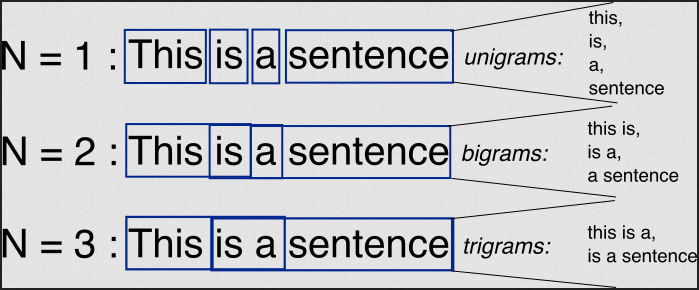

**ngram_range ** tuple (min_n, max_n) default=(1,1): Representa el limite inferior y superior para los n-grams en la extracción del texto ngram_range=(1,2) representa unigrams y bigrams a aplicarse

**max_df** parametros para ignorar terminos demasiado frecuentes que superan el umbral

**min_df** parametros para ignorar terminos frecuentes que superan el umbral

**max_features:** crea un vocabulario que solo tenga el top max_features ordenadas por frecuencia de términos en todo el corpus.

fuente: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html


In [59]:
# Eleccion de parametros
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

In [60]:
# Corpus Propio
features_train_cp,features_test_cp,labels_train_cp,labels_test_cp,tfidf_cp=tifdf_features(X_train_cp, X_test_cp, y_train_cp, y_test_cp,ngram_range,max_df,min_df,max_features)

In [61]:
# Corpus Unido
features_train,features_test,labels_train,labels_test,tfidf=tifdf_features(X_train, X_test, y_train, y_test,ngram_range,max_df,min_df,max_features)

## Modelos de clasificación

Metricas de evaluación

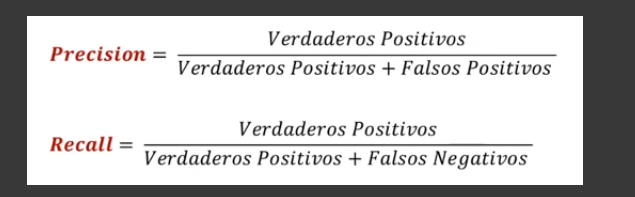

### **RandomForestClassifier**


In [136]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
hyperparameters_tuning = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(hyperparameters_tuning)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


#### **RandomForest Classifier - Corpus del proyecto**

In [137]:
%%time
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search_cp = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=hyperparameters_tuning,
                                   n_iter=150,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search_cp.fit(features_train_cp, labels_train_cp)
print("The best hyperparameters from Random Search are:")
print(random_search_cp.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search_cp.best_score_)

Fitting 3 folds for each of 150 candidates, totalling 450 fits
The best hyperparameters from Random Search are:
{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}

The mean accuracy of a model with these hyperparameters is:
0.8463013594592542
CPU times: user 7min 39s, sys: 2.73 s, total: 7min 41s
Wall time: 7min 47s


In [138]:
# se entrena el modelo con los parametros encontrados en la busqueda aleatoria.
clf_cp = RandomForestClassifier(n_estimators=1000, min_samples_split=2,min_samples_leaf=2, max_features='auto', max_depth=None, bootstrap=True)
clf_cp.fit(features_train_cp, labels_train_cp)
clf_predict_cp = clf_cp.predict(features_test_cp)

Text(39.49999999999999, 0.5, 'Predicted')

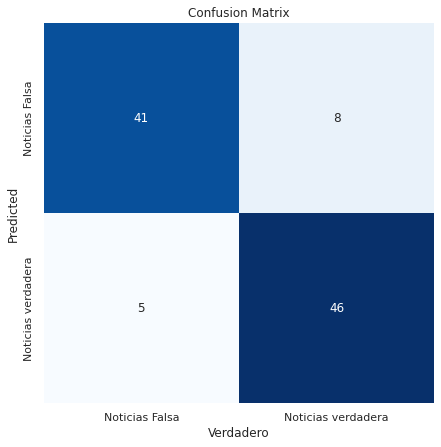

In [139]:
# Matrix de confunsión 500 noticias
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, clf_predict_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [140]:
accuracy_randomforest_cp=accuracy_score(labels_test_cp, clf_predict_cp)
print("Accuracy Corpus propio",accuracy_randomforest_cp)

Accuracy Corpus propio 0.87


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


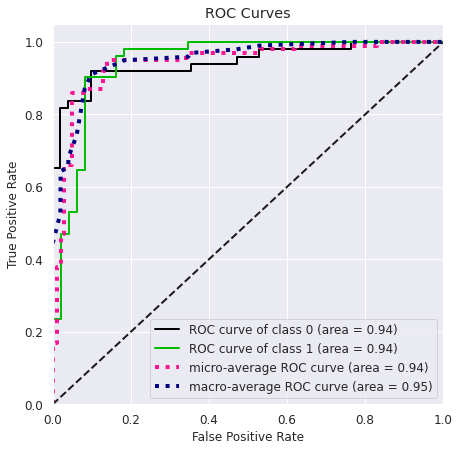

In [141]:
clf_predict_proba_cp = clf_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp, clf_predict_proba_cp)
plt.show()

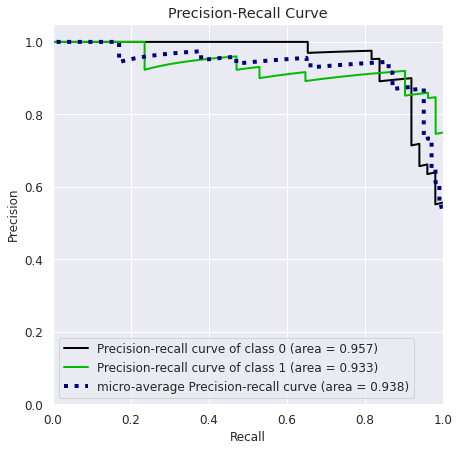

In [142]:
skplt.metrics.plot_precision_recall(labels_test_cp,clf_predict_proba_cp)

#### **RandomForest Classifier - Corpus Unido**

In [143]:
%%time
# First create the base model to tune
rfc = RandomForestClassifier(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=hyperparameters_tuning,
                                   n_iter=100,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(features_train, labels_train)
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
The best hyperparameters from Random Search are:
{'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': True}

The mean accuracy of a model with these hyperparameters is:
0.7569188443789083
CPU times: user 8min 49s, sys: 2.46 s, total: 8min 52s
Wall time: 8min 52s


In [144]:
# se entrena el modelo con los parametros encontrados en la busqueda aleatoria.
clf = RandomForestClassifier(n_estimators=1000, min_samples_split=2,min_samples_leaf=1, max_features='auto', max_depth=80, bootstrap=True)
clf.fit(features_train, labels_train)
clf_predict = clf.predict(features_test)

Text(39.49999999999999, 0.5, 'Predicted')

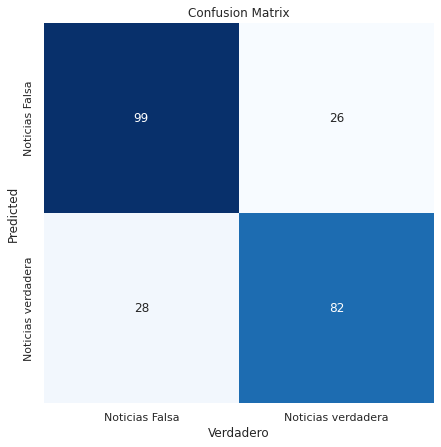

In [145]:
# Matrix de confunsión 1000 noticias
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, clf_predict)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

In [146]:
accuracy_randomforest=accuracy_score(labels_test, clf_predict)
print(accuracy_randomforest)

0.7702127659574468


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


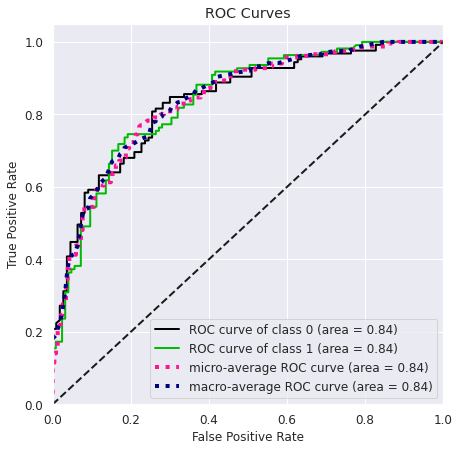

In [147]:
clf_predict_proba = clf.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test, clf_predict_proba)
plt.show()

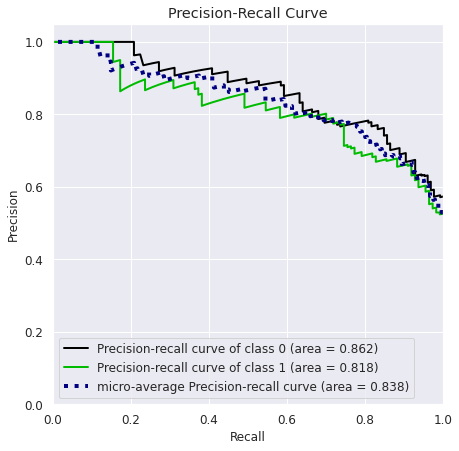

In [148]:
skplt.metrics.plot_precision_recall(labels_test,clf_predict_proba)

## **Naive Bayes**

### **Naive Bayes Corpus del proyecto**

In [149]:
hyperparameters_tuning ={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),'fit_prior' : [True, False]}
best_model_nb_cp,predictions_nb_cp,accuracy_nb_cp=randomsearchmodels(MultinomialNB(),hyperparameters_tuning,features_train_cp,labels_train_cp,features_test_cp,labels_test_cp)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 12 is smaller than n_iter=150. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


In [150]:
MultinomialNB().get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

In [151]:
print("Naive Bayes Accuracy Score -> ",accuracy_nb_cp)

Naive Bayes Accuracy Score ->  0.76


Text(39.49999999999999, 0.5, 'Predicted')

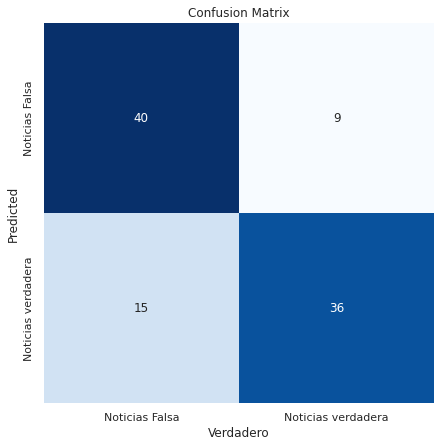

In [152]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, predictions_nb_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


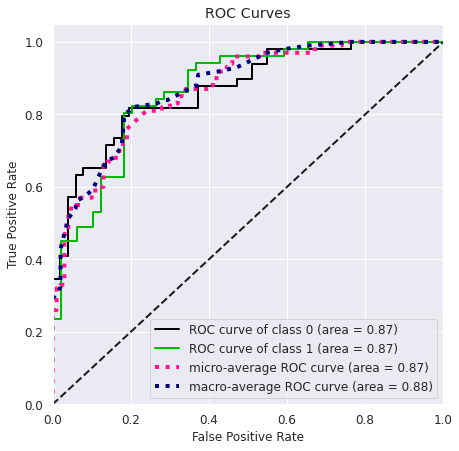

In [153]:
predict_nb_cp=best_model_nb_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp, predict_nb_cp)
plt.show()

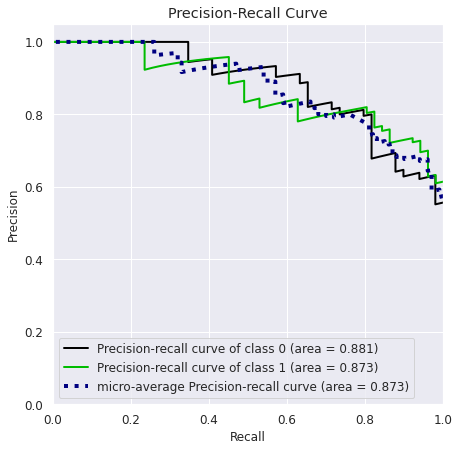

In [154]:
skplt.metrics.plot_precision_recall(labels_test_cp,predict_nb_cp)

### **Naive Bayes Corpus Unido**

In [155]:
hyperparameters_tuning ={'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001),'fit_prior' : [True, False]}
best_model_nb,predictions_nb,accuracy_nb=randomsearchmodels(MultinomialNB(),hyperparameters_tuning,features_train,labels_train,features_test,labels_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 12 is smaller than n_iter=150. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


In [156]:
print("Naive Bayes Accuracy Score -> ",accuracy_nb)

Naive Bayes Accuracy Score ->  0.7106382978723405


Text(39.49999999999999, 0.5, 'Predicted')

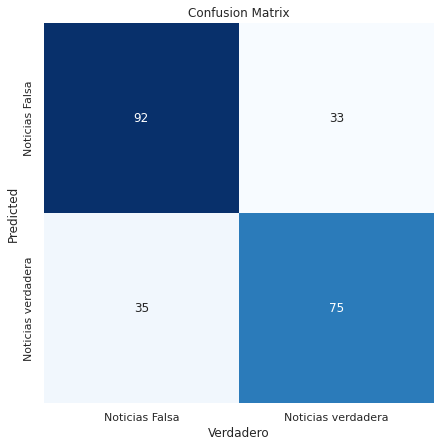

In [157]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_nb)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


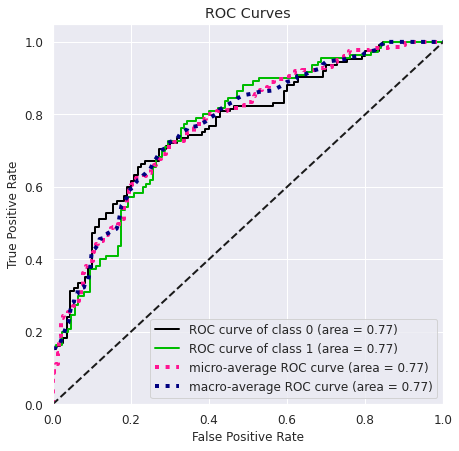

In [158]:
predict_nb=best_model_nb.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test, predict_nb)
plt.show()

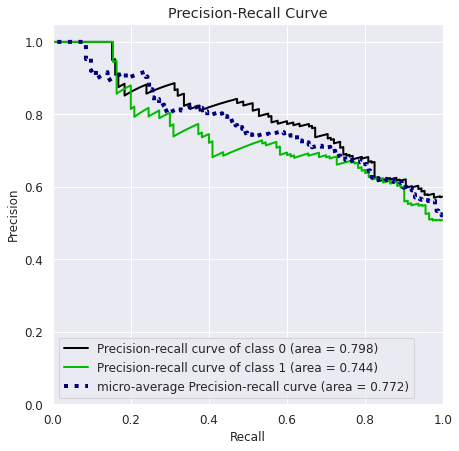

In [159]:
skplt.metrics.plot_precision_recall(labels_test,predict_nb)

## **SVC**

### **SVC Corpus del proyecto**

In [160]:
print(features_train_cp.shape)
print(labels_train_cp.shape)
print(features_test_cp.shape)

(397, 178)
(397,)
(100, 178)


In [161]:
print(type(features_train_cp))
print(type(labels_train_cp))
print(type(features_test_cp))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'pandas.core.series.Series'>
<class 'scipy.sparse.csr.csr_matrix'>


In [162]:
print(type(features_train))
print(type(labels_train))
print(type(features_test))

<class 'scipy.sparse.csr.csr_matrix'>
<class 'pandas.core.series.Series'>
<class 'scipy.sparse.csr.csr_matrix'>


In [163]:
print(features_train.shape)
print(labels_train.shape)
print(features_test.shape)

(938, 300)
(938,)
(235, 300)


In [164]:
hyperparameters_tuning = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf','sigmoid']}
best_model_svc_cp,predictions_svc_cp,accuracy_svc_cp=randomsearchmodels(SVC(probability=True),hyperparameters_tuning,features_train_cp,labels_train_cp,features_test_cp,labels_test_cp)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 48 is smaller than n_iter=150. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


In [165]:
print("SVM Accuracy Score -> ",accuracy_svc_cp)

SVM Accuracy Score ->  0.85


Text(39.49999999999999, 0.5, 'Predicted')

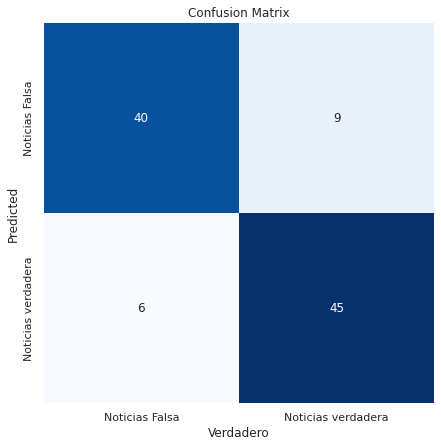

In [166]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, predictions_svc_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


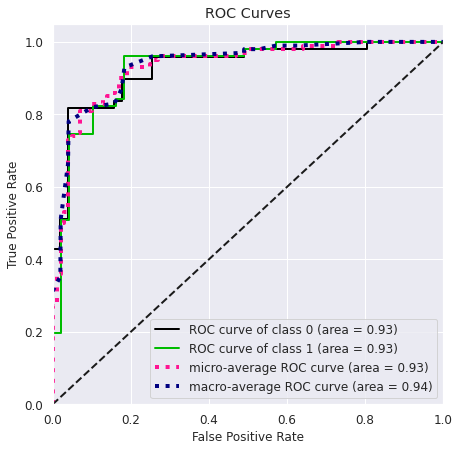

In [167]:
predict_svc_cp=best_model_svc_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp, predict_svc_cp)
plt.show()

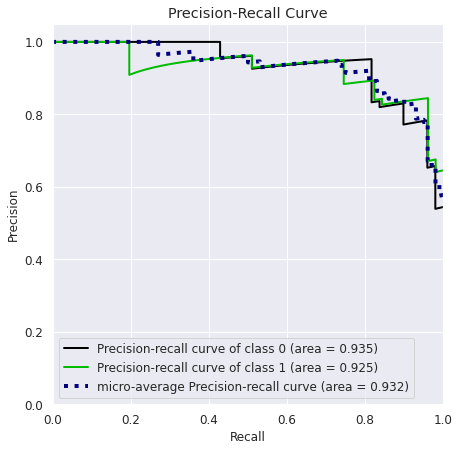

In [168]:
skplt.metrics.plot_precision_recall(labels_test_cp,predict_svc_cp)

### **SVC Corpus Unido**

In [169]:
hyperparameters_tuning = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf','sigmoid']}
best_model_svc,predictions_svc,accuracy_svc=randomsearchmodels(SVC(probability=True),hyperparameters_tuning,features_train,labels_train,features_test,labels_test)                                       

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 48 is smaller than n_iter=150. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 3 folds for each of 48 candidates, totalling 144 fits


In [170]:
print("SVM Accuracy Score -> ",accuracy_svc)

SVM Accuracy Score ->  0.7446808510638298


Text(39.49999999999999, 0.5, 'Predicted')

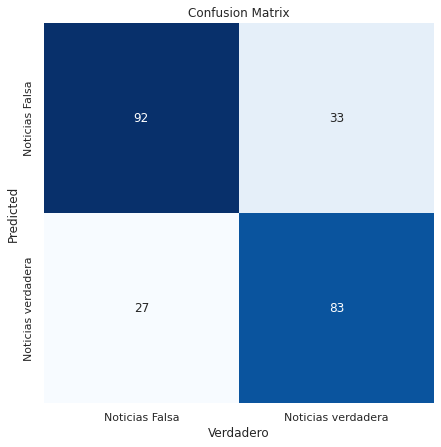

In [171]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_svc)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


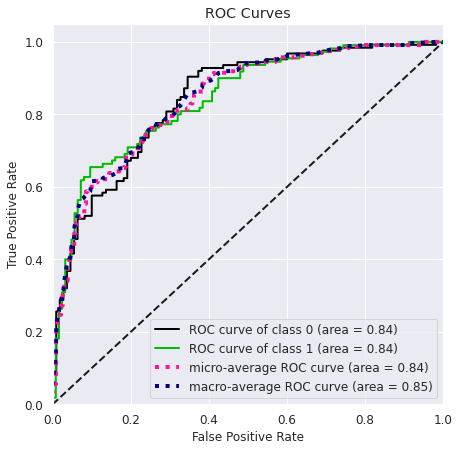

In [172]:
predict_svc=best_model_svc.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test, predict_svc)
plt.show()

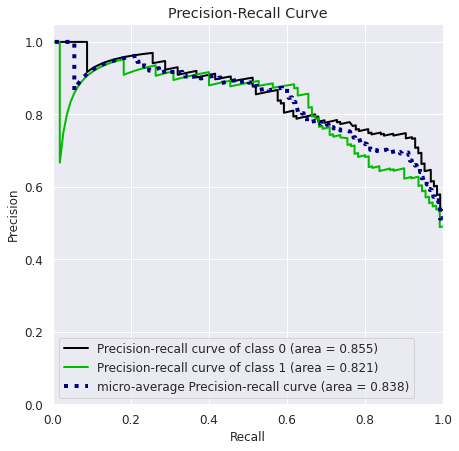

In [173]:
skplt.metrics.plot_precision_recall(labels_test,predict_svc)

## **Logistic Regression**

### **Logistic Regression Corpus del proyecto**

In [174]:
hyperparameters_tuning = {'C':np.logspace(-2,1,100),'penalty':['l2']}
#hyperparameters_tuning = {'C':np.logspace(-2,1,100),'solver': ['newton-cg', 'lbfgs', 'liblinear'],'penalty': ['none', 'l2']}
best_model_logistic_cp,predictions_logistic_cp,accuracy_logistic_cp=randomsearchmodels(LogisticRegression(class_weight='balanced'),hyperparameters_tuning,features_train_cp,labels_train_cp,features_test_cp,labels_test_cp)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 100 is smaller than n_iter=150. Running 100 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [175]:
print("Logistic Regression Accuracy Score -> ",accuracy_logistic_cp)

Logistic Regression Accuracy Score ->  0.86


Text(39.49999999999999, 0.5, 'Predicted')

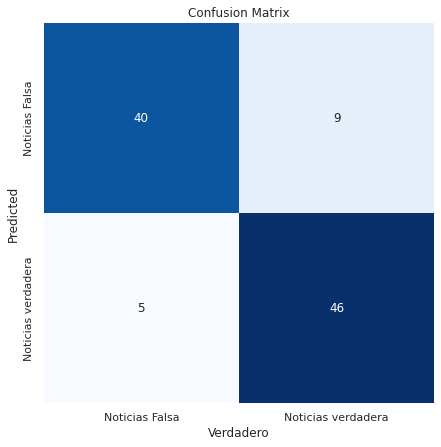

In [176]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, predictions_logistic_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


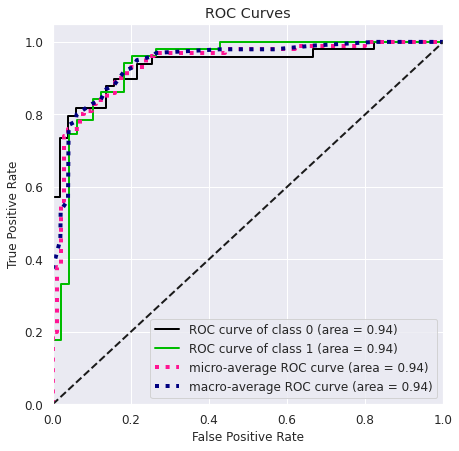

In [177]:
y_pred_proba_cp= best_model_logistic_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp,y_pred_proba_cp)
plt.show()

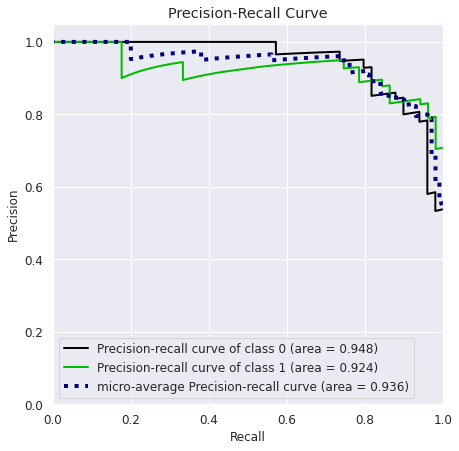

In [178]:
skplt.metrics.plot_precision_recall(labels_test_cp,y_pred_proba_cp)

### **Logistic Regression Corpus Unido**

In [179]:
hyperparameters_tuning = {'C':np.logspace(-2,1,100),'penalty':['l2']}
#hyperparameters_tuning = {'C':np.logspace(-2,1,100),'solver': ['newton-cg', 'lbfgs', 'liblinear'],'penalty': ['none', 'l2']}
best_model_logistic,predictions_logistic,accuracy_logistic=randomsearchmodels(LogisticRegression(class_weight='balanced'),hyperparameters_tuning,features_train,labels_train,features_test,labels_test)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 100 is smaller than n_iter=150. Running 100 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [180]:
print("Logistic Regression Accuracy Score -> ",accuracy_logistic)

Logistic Regression Accuracy Score ->  0.7446808510638298


Text(39.49999999999999, 0.5, 'Predicted')

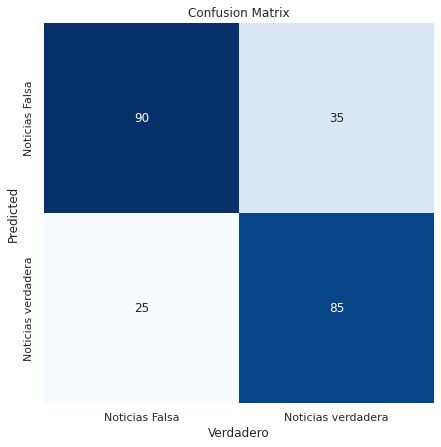

In [181]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_logistic)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


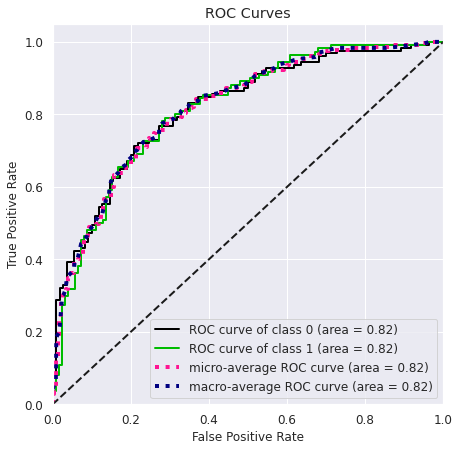

In [182]:
y_pred_proba= best_model_logistic.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test,y_pred_proba)
plt.show()

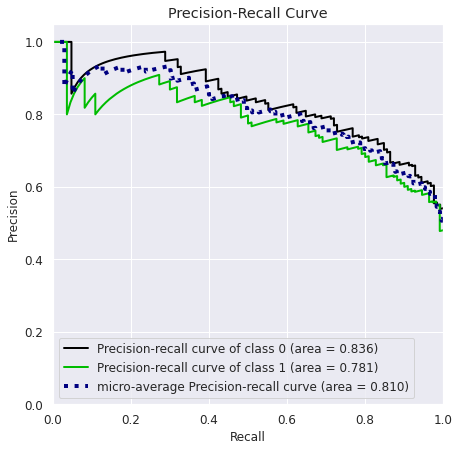

In [183]:
skplt.metrics.plot_precision_recall(labels_test,y_pred_proba)

## **XGBoost**

### **XGBoost Corpus del proyecto**

In [184]:
hyperparameters_tuning={'colsample_bytree' : [0.3, 0.5, 1.0],'gamma' : [0.1, 1, 1.5],'learning_rate' : [0.1, 0.01, 0.05,0.9],'min_child_weight' : [1, 5, 10],'scale_pos_weight' : [1, 2, 4],'subsample' : [0.8, 0.9, 1.0],'n_estimators' : [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)],'max_depth' : [3,5,7,9],'reg_alpha':[0.1, 0.01, 0.05],'eta_vals': [0.001, 0.01, 0.1]}
best_model_xgb_cp,predictions_xgb_cp,accuracy_xgb_cp=randomsearchmodels(xgb.XGBClassifier(objective= 'binary:logistic',nthread=4,seed=42),hyperparameters_tuning,features_train_cp,labels_train_cp,features_test_cp,labels_test_cp)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


In [185]:
print("XGBoost Accuracy Score: ",accuracy_xgb_cp)

XGBoost Accuracy Score:  0.9


Text(39.49999999999999, 0.5, 'Predicted')

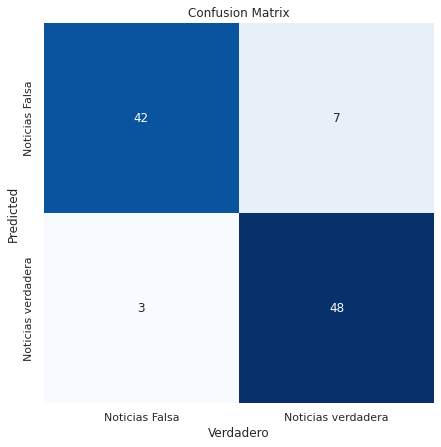

In [186]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test_cp, predictions_xgb_cp)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


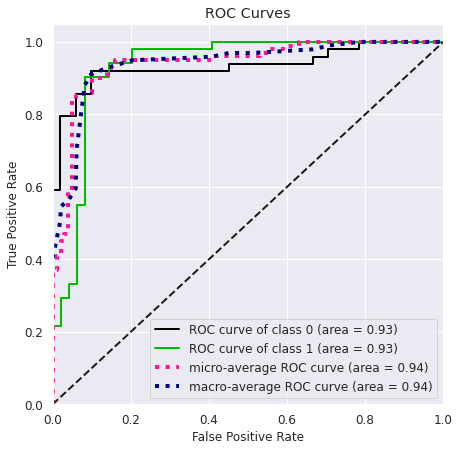

In [187]:
y_pred_proba_cp= best_model_xgb_cp.predict_proba(features_test_cp)
skplt.metrics.plot_roc_curve(labels_test_cp,y_pred_proba_cp)
plt.show()

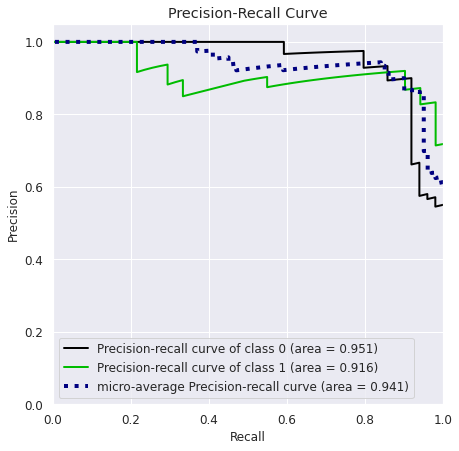

In [188]:
skplt.metrics.plot_precision_recall(labels_test_cp,y_pred_proba_cp)

### **XGBoost Corpus Unido**

In [189]:
hyperparameters_tuning={'colsample_bytree' : [0.3, 0.5, 1.0],'gamma' : [0.1, 1, 1.5],'learning_rate' : [0.1, 0.01, 0.05,0.9],'min_child_weight' : [1, 5, 10],'scale_pos_weight' : [1, 2, 4],'subsample' : [0.8, 0.9, 1.0],'n_estimators' : [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)],'max_depth' : [3,5,7,9],'reg_alpha':[0.1, 0.01, 0.05],'eta_vals': [0.001, 0.01, 0.1]}
best_model_xgb,predictions_xgb,accuracy_xgb=randomsearchmodels(xgb.XGBClassifier(objective= 'binary:logistic',nthread=4,seed=42),hyperparameters_tuning,features_train,labels_train,features_test,labels_test)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


In [190]:
print("XGBoost Accuracy Score: ",accuracy_xgb)

XGBoost Accuracy Score:  0.7574468085106383


Text(39.49999999999999, 0.5, 'Predicted')

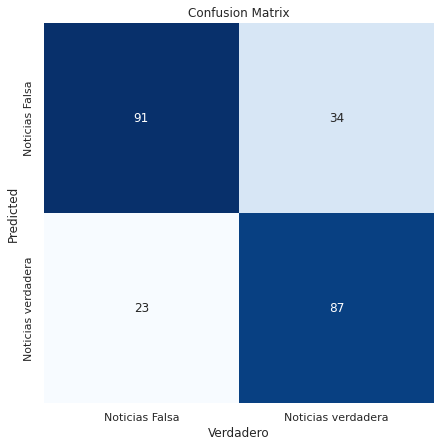

In [191]:
sns.set(rc={'figure.figsize':(7,7)})
class_names=['Noticias Falsa','Noticias verdadera']
matrix=confusion_matrix(labels_test, predictions_xgb)
# create dataframe
dataframe_graf=pd.DataFrame(matrix, index=class_names, columns=class_names)
# create headmap
sns.heatmap(dataframe_graf, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Verdadero")
plt.ylabel("Predicted")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


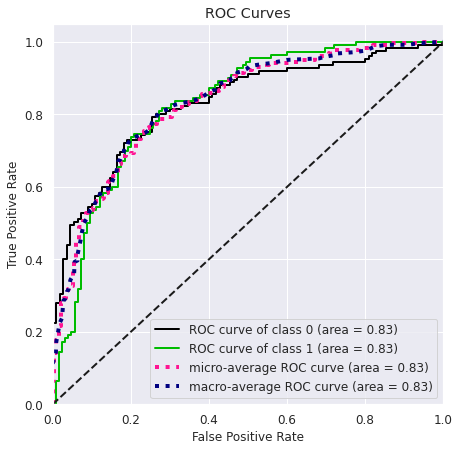

In [192]:
y_pred_proba= best_model_xgb.predict_proba(features_test)
skplt.metrics.plot_roc_curve(labels_test,y_pred_proba)
plt.show()

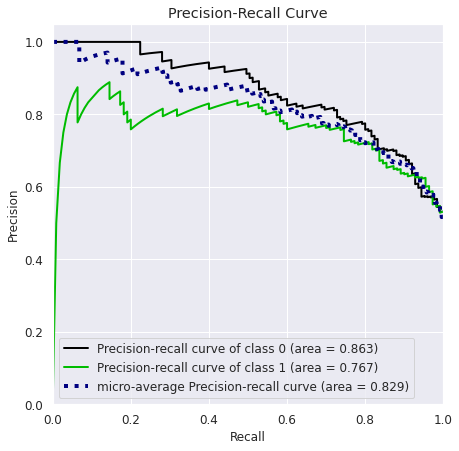

In [193]:
skplt.metrics.plot_precision_recall(labels_test,y_pred_proba)

## Redes Neuronales

#**Evaluación**

###**Evaluación de Modelos con Corpus Propio**

In [194]:
listas_cp=[["Random Forest",accuracy_randomforest_cp],["Naive Bayes",accuracy_nb_cp],["SVC",accuracy_svc_cp],["Logistic Regression",accuracy_logistic_cp],["XGBoost",accuracy_xgb_cp]]
df_listas_cp=pd.DataFrame(listas_cp,columns=["Modelos","Metrica - Accuracy"])
df_listas_cp
df_listas_cp.style.set_properties(**{'border': '1.3px solid black','text-align': 'center',
                          'color': '#504C4C'})

###**Evaluación de Modelos con el Corpus Unido**

In [195]:
listas=[["Random Forest",accuracy_randomforest],["Naive Bayes",accuracy_nb],["SVC",accuracy_svc],["Logistic Regression",accuracy_logistic],["XGBoost",accuracy_xgb]]
df_listas=pd.DataFrame(listas,columns=["Modelos","Metrica - Accuracy"])
df_listas
df_listas.style.set_properties(**{'border': '1.3px solid black','text-align': 'center',
                          'color': '#504C4C'})

# **Pruebas**

In [237]:
def detection_fake_news_(news):
    news=text_preprocessing(news)
    input_data = [news]
    vectorized_input_data = tfidf_cp.transform(input_data)
    prediction = best_model_svc_cp.predict(vectorized_input_data)
    prediction_proba = best_model_svc_cp.predict_proba(vectorized_input_data)
    print (prediction_proba)
     
    if prediction==0:
      print ("La noticia que ingreso es real con una probabilidad de:",prediction_proba[0][0])
    else:
        print ("La noticia que ingreso es falsa con una probabilidad de:",prediction_proba[0][1])

In [238]:
detection_fake_news_("En medio de uno de los momentos más difíciles para la Coalición Centro Esperanza, y justo cuando la Contraloría declaró reparado el daño patrimonial de $4,3 billones en el caso Hidroituango, el precandidato presidencial Sergio Fajardo habló con EL COLOMBIANO sobre ambos temas.")

[[0.90440097 0.09559903]]
La noticia que ingreso es real con una probabilidad de: 0.9044009670741374


# **Modelos para producción**

### Se guardan los modelos para su paso a producción

In [226]:
create_model_production("RF",clf)
create_model_production("NB",best_model_nb)
create_model_production("SVC",best_model_svc)
create_model_production("LR",best_model_logistic)
create_model_production("Xgboost",best_model_xgb)
create_model_production("vectorizer",tfidf)